In [3]:
from os.path import exists 
import pandas as pd
import shap
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *


task = "cyp3a4"

In [4]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
3,CatBoost,0.85,0.82,0.70,0.150,0.150
4,CatBoost_iloc3,0.84,0.82,0.70,0.090,0.200
7,XGBoost,0.84,0.82,0.70,0.079,0.210
6,XGBoost,0.84,0.82,0.69,0.099,0.190
0,SVC,0.85,0.81,0.68,0.170,0.140
1,RandomForest,0.83,0.79,0.65,0.200,0.140
2,LogisticRegression,0.82,0.78,0.63,0.180,0.190
5,KNN,0.77,0.66,0.52,0.460,0.077


# Data

In [5]:
# load thedataset
data = data_preprocessing(task)

# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

# druglike molecules
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

# remove NaN values
data_nan = extract_null(data)
data = data.drop(data_nan.index)

display(data)

# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Dataset already exists, returning data/cyp3a4/raw_dataset.csv.
Number of molecules before druglikeliness selection: 12328
Number of druglike molecules: 11864


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,644510.0,13.221898,-0.305076,13.221898,0.022394,0.383547,466.473,443.289,...,0,0,0,0,0,0,0,0,0,0
2,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
4,0,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,645063.0,12.762343,-0.533851,12.762343,0.182110,0.757037,380.448,356.256,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12323,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12324,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12325,0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12326,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


# CatBoost

In [7]:
file_loc = f"optimization/{task}/catboost_0.csv"

# print comments
comments = ""
with open(file_loc, "r") as f:
    for line in f:
        if line[0] == "#":
            comments+=line

print(comments)

# print hyperparameter optimization results
pd.read_csv(file_loc, comment="#").drop("Unnamed: 0", axis=1).sort_values("val_mcc", ascending=False).head()

# fix_model_params={'verbose': 0}
# main_metric=mcc
# model_params=[Integer(low=4, high=12, prior='uniform', transform='identity'), Real(low=2.0, high=10.0, prior='uniform', transform='identity'), Real(low=1, high=6, prior='uniform', transform='identity')]
# preprocessing_params=None



,max_depth,l2_leaf_reg,scale_pos_weight,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
46,9,3.951761,1.535843,0.006960,0.034635,0.021205,0.875925,0.852792,0.819876,0.792000,0.849785,0.696906,0.926697,0.885065
50,8,5.479604,1.176470,0.004038,0.046546,0.021466,0.860905,0.853638,0.816543,0.807128,0.826180,0.694956,0.927332,0.885260
48,10,8.950058,1.781150,0.009848,0.048644,0.007633,0.825357,0.849408,0.819473,0.776923,0.866953,0.694020,0.927416,0.888121
11,9,2.972073,3.474291,0.041872,0.006576,0.047127,0.985911,0.842640,0.820116,0.746479,0.909871,0.693245,0.927024,0.881909
45,9,4.387351,2.101832,0.000733,0.022344,0.047549,0.817076,0.847716,0.817814,0.773946,0.866953,0.690989,0.924893,0.881813


In [8]:
model = CatBoostClassifier(
    max_depth=9, l2_leaf_reg=3.951761, scale_pos_weight=1.535843, verbose=0
)

data_prep = DataPreprocessing(
    feature_groups,
    var_threshold={
        "continuous": 0.006960,
        "discrete": 0.034635,
        "fingerprint": 0.021205,
    },
    corr_threshold=0.875925,
)


data_prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_prep = data_prep.transform(datasets["train"].drop("Y", axis=1))
x_val_prep = data_prep.transform(datasets["val"].drop("Y", axis=1))
x_test_prep = data_prep.transform(datasets["test"].drop("Y", axis=1))

model.fit(x_train_prep, datasets["train"]["Y"])

0:	learn: 0.6799780	total: 189ms	remaining: 3m 9s
1:	learn: 0.6672720	total: 321ms	remaining: 2m 40s
2:	learn: 0.6548337	total: 461ms	remaining: 2m 33s
3:	learn: 0.6434546	total: 613ms	remaining: 2m 32s
4:	learn: 0.6337398	total: 762ms	remaining: 2m 31s
5:	learn: 0.6244855	total: 905ms	remaining: 2m 29s
6:	learn: 0.6146517	total: 1.02s	remaining: 2m 24s
7:	learn: 0.6069722	total: 1.15s	remaining: 2m 22s
8:	learn: 0.5977129	total: 1.27s	remaining: 2m 19s
9:	learn: 0.5893698	total: 1.39s	remaining: 2m 17s
10:	learn: 0.5822865	total: 1.52s	remaining: 2m 16s
11:	learn: 0.5759500	total: 1.64s	remaining: 2m 15s
12:	learn: 0.5698344	total: 1.76s	remaining: 2m 13s
13:	learn: 0.5633015	total: 1.88s	remaining: 2m 12s
14:	learn: 0.5571427	total: 1.99s	remaining: 2m 10s
15:	learn: 0.5522276	total: 2.11s	remaining: 2m 9s
16:	learn: 0.5473030	total: 2.21s	remaining: 2m 7s
17:	learn: 0.5422442	total: 2.32s	remaining: 2m 6s
18:	learn: 0.5372772	total: 2.43s	remaining: 2m 5s
19:	learn: 0.5328614	total:

Accuracy: 85.28%
F1-score: 81.99%
Matthews correlation coefficient: 0.6969060637818747%


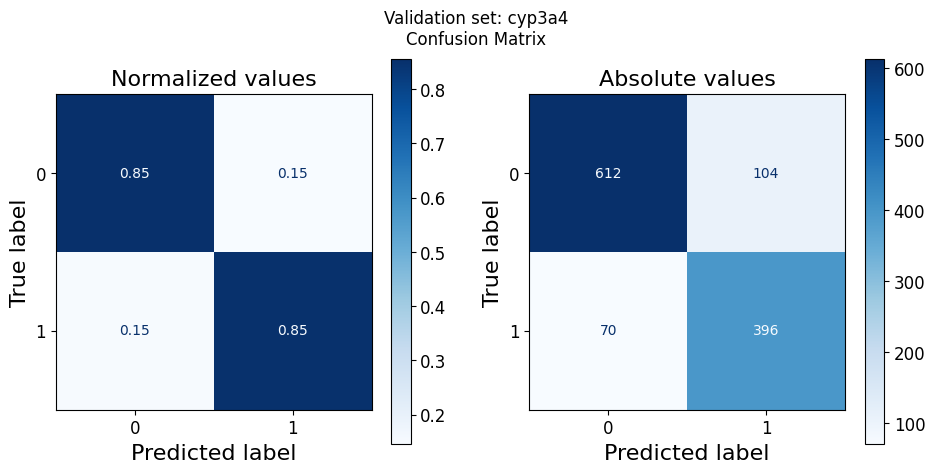

Accuracy: 82.54%
F1-score: 79.58%
Matthews correlation coefficient: 0.6469134740098862%


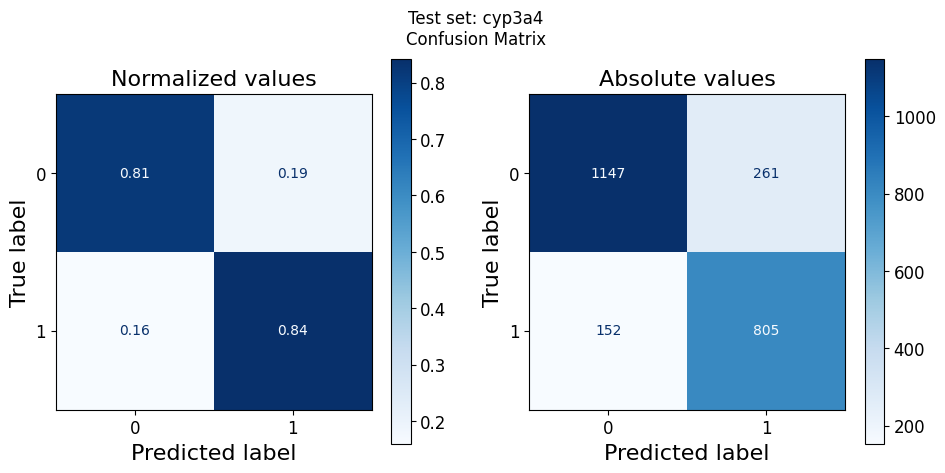

In [9]:
y_val_pred = model.predict(x_val_prep)
conf_matrix(datasets["val"]["Y"], y_val_pred, f"Validation set: {task}")

y_test_pred = model.predict(x_test_prep)
conf_matrix(datasets["test"]["Y"], y_test_pred, f"Test set: {task}")

## SHAP

In [10]:
# Add feature names to x_train_prep

data_norm = MinMaxScaler().fit_transform(datasets["train"].drop("Y", axis=1))
d1 = pd.DataFrame(data_norm, columns=datasets["train"].drop("Y", axis=1).columns)

d2 = pd.DataFrame(x_train_prep)
df = pd.concat([d2, d1], axis=1).T

x_train_prep_shap = df[df.duplicated()].T
model.fit(x_train_prep_shap, datasets["train"]["Y"])

0:	learn: 0.6795862	total: 145ms	remaining: 2m 25s
1:	learn: 0.6677030	total: 266ms	remaining: 2m 12s
2:	learn: 0.6551091	total: 389ms	remaining: 2m 9s
3:	learn: 0.6447010	total: 519ms	remaining: 2m 9s
4:	learn: 0.6344824	total: 646ms	remaining: 2m 8s
5:	learn: 0.6236773	total: 782ms	remaining: 2m 9s
6:	learn: 0.6137228	total: 908ms	remaining: 2m 8s
7:	learn: 0.6055253	total: 1.03s	remaining: 2m 7s
8:	learn: 0.5966677	total: 1.16s	remaining: 2m 7s
9:	learn: 0.5901393	total: 1.29s	remaining: 2m 8s
10:	learn: 0.5830452	total: 1.43s	remaining: 2m 8s
11:	learn: 0.5759319	total: 1.58s	remaining: 2m 10s
12:	learn: 0.5698551	total: 1.75s	remaining: 2m 13s
13:	learn: 0.5637785	total: 1.89s	remaining: 2m 13s
14:	learn: 0.5588161	total: 2.05s	remaining: 2m 14s
15:	learn: 0.5542043	total: 2.21s	remaining: 2m 16s
16:	learn: 0.5486317	total: 2.39s	remaining: 2m 18s
17:	learn: 0.5428104	total: 2.57s	remaining: 2m 20s
18:	learn: 0.5382234	total: 2.73s	remaining: 2m 21s
19:	learn: 0.5325642	total: 2.8

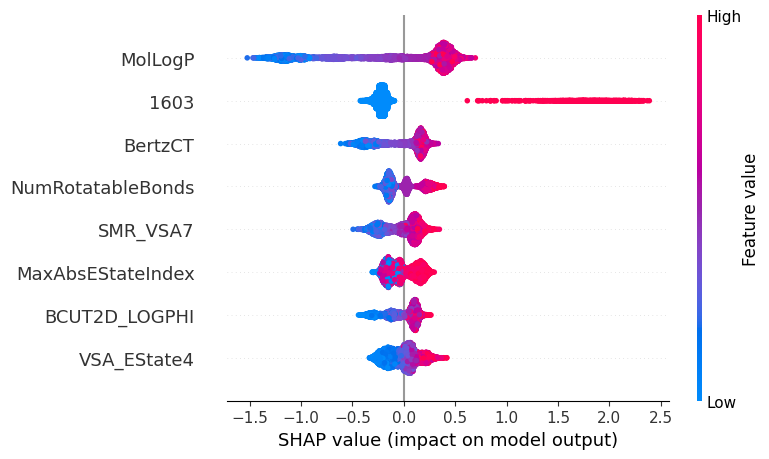

In [12]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_prep_shap)
shap.summary_plot(shap_values, x_train_prep_shap, max_display=8)